# Base functions & import data

In [59]:
#######
# cmd #
#######
# ! python -m pip install --upgrade pip
# ! pip install --pre pandas==2.0.0rc0
#pd.options.mode.dtype_backend = 'pyarrow'


# , engine='pyarrow', use_nullable_dtypes=True
# 1m 15.9s w/ old pandas
# 5.9s w/ new pandas

############
### Note ###
############
# sales_train_eva contempla o sales_train_val e ainda adciona observacoes das vendas dos dias d_1914 - d_1941
# id = ..._validation => até d_1913
# id = ..._evaluation => até d_1941

############
### Goal ###
############
# validation part of submission sample => cross validation w/ d_1 to d_1913 => calculate sMAPE e MASE w/ d_1914 to d_1941
# evaluation part of submission sample => cross validation w/ d_1 to d_1941 => calculate M5 final score in kaggle by
                                                                                    # concatenating these parts


############################################
########## IMPORTACAO DOS DADOS ############
############################################
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import os
import random
import seaborn as sns
import warnings

if os.path.exists('C:/Users/u00378/Desktop/PIBIC_2021-2022/data_from_kaggle'):
    INPUT_DIR = 'C:/Users/u00378/Desktop/PIBIC_2021-2022/data_from_kaggle'
else:
    INPUT_DIR = 'C:/Users/Igor/Desktop/PIBIC/PIBIC_2021-2022/data_from_kaggle'

calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
selling_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sales_train_val = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv') # sales_train d_1 ate
                                                                                                                            # d_1913
sales_train_eva = pd.read_csv(f'{INPUT_DIR}/sales_train_evaluation.csv') # sales_train d_1 ate
                                                                                                                            # d_1941
cols = []

for i in range(1, 1942, 1):
    col = f"d_{i}"
    cols.append(col)

sales_train = pd.concat([sales_train_val, sales_train_eva[cols[-28:]]], axis = 1)
sales_train['id'] = sales_train['id'].apply(lambda w : w.replace('_validation', ''))

calendar['date'] = pd.to_datetime(calendar['date'])

#################################################
### Filtros para alcançar as series temporais ###
#################################################
def filter_item_store(item_id, store_id):
    '''
    Funcao para filtrar os dados no nivel mais desagregado possivel - venda do item_id na store_id

    '''
    v = sales_train[(sales_train['item_id']== item_id) & (sales_train['store_id']== store_id)][cols].sum().values

    #, dtype = 'int64[pyarrow]'
    return pd.Series(v, index = calendar['date'][:-28])


def filter_dept_store(dept_id, store_id):
    '''
    Funcao para filtrar os dados no nivel da venda de todos os item_id do dept_id na store_id

    '''
    v = sales_train[(sales_train['dept_id']== dept_id) & (sales_train['store_id']== store_id)][cols].sum().values

    # , dtype = 'int64[pyarrow]'
    return pd.Series(v, index = calendar['date'][:-28])

def filter_store(store_id):
    '''
    Funcao para filtrar os dados no nivel da venda de todos os item_id na store_id

    '''
    v = sales_train[sales_train['store_id'] == store_id][cols].sum().values

    # , dtype = 'int64[pyarrow]'
    return pd.Series(v, index = calendar['date'][:-28])


def no_filter():
    '''
    Funcao para alcancar as vendas no nivel mais agregado possivel - vendas diarias da walmart como um todo

    '''
    v = sales_train[cols].sum().values
    
    # , dtype = 'int64[pyarrow]'
    return pd.Series(v, index = calendar['date'][:-28])


########################################################
### Filtros para alcanças as variaveis explanatorias ###
########################################################
def get_price(dept_id, store_id):
    '''
    retorna a variação percentual média dos preços dos item_id vendidos no dept_id na store_id

    '''
    itens = np.unique(sales_train[(sales_train['dept_id'] == dept_id) & (sales_train['store_id'] == store_id) ]['item_id'])
    v = selling_prices[(selling_prices['store_id'] == store_id) & (selling_prices['item_id'].isin(itens))].copy()
    v['pct_change_sell_price'] = v['sell_price'].pct_change()
    v.fillna(0, inplace = True)

    data = pd.merge(v, calendar[['wm_yr_wk', 'date', 'd']], on = 'wm_yr_wk', how = 'inner')[['date', 'd', 'pct_change_sell_price']]
    return pd.Series(data = data['pct_change_sell_price'].values, index = data['date']).resample('D').mean()

def get_price_total():
    '''
    retorna a variação percentual média dos preços dos item_id vendidos pela walmart

    '''
    v = selling_prices.copy()
    v['pct_change_sell_price'] = v['sell_price'].pct_change()
    v.fillna(0, inplace = True)

    data = pd.merge(v, calendar[['wm_yr_wk', 'date', 'd']], on = 'wm_yr_wk', how = 'inner')[['date', 'd', 'pct_change_sell_price']]
    return pd.Series(data = data['pct_change_sell_price'].values, index = data['date']).resample('D').mean()

def get_exp_var():
    exp_var = calendar[['date', 'd', 'weekday', 'event_type_1', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI']].copy()
    exp_var.fillna('No_event', inplace = True)

    dummies = pd.get_dummies(\
        exp_var[['event_type_1', 'event_type_2', 'weekday']])

    for i in dummies.columns:
        a = f"{i}"
        exp_var[a] = dummies[a]

    exp_var = exp_var.drop(['event_type_1', 'event_type_2', 'event_type_1_No_event', 'event_type_2_No_event', 'weekday',\
                            'weekday_Wednesday'], axis = 1)
    
    return exp_var

# EDA

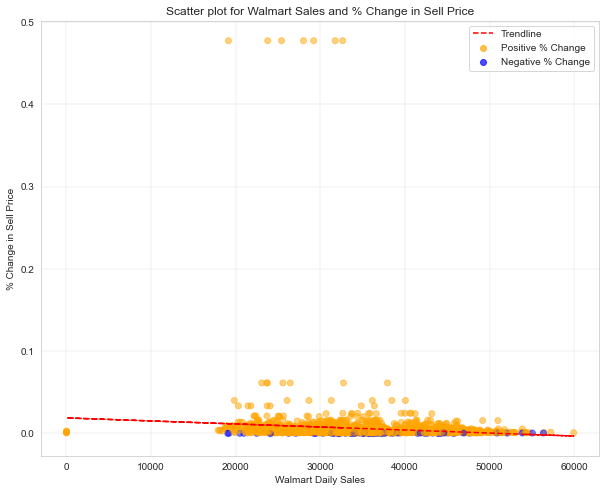

In [60]:
# Set seaborn as the style for the plot
sns.set_style("whitegrid")

#data
prices = get_price_total()    
x = np.array(no_filter().values)
y = np.array(prices[0:-28].values)

# Define colors based on positive or negative change in sell price
colors = ['orange' if val > 0 else 'blue' for val in y]

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Create scatter plot with colors based on y values
ax.scatter(x, y, c=colors, alpha=0.5)

# Add title and labels
plt.title('Scatter plot for Walmart Sales and % Change in Sell Price')
plt.ylabel('% Change in Sell Price')
plt.xlabel('Walmart Daily Sales')

# Add trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x, p(x), 'r--', label='Trendline')

# Set the legend labels
legend_labels = ['Positive % Change', 'Negative % Change']

# Create scatter plots for each color with the respective label
orange = ax.scatter(x[colors == 'orange'], y[colors == 'orange'],
                    c='orange', alpha=0.7, label=legend_labels[0])
blue = ax.scatter(x[colors == 'blue'], y[colors == 'blue'],
                c='blue', alpha=0.7, label=legend_labels[1])

# Add legend
ax.legend()

# Add gridlines
ax.grid(color='gray', linestyle='-', linewidth=0.25, alpha=0.5)

# save figure
plt.savefig("C:/Users/Igor/Desktop/PIBIC/PIBIC_2021-2022/images/scatter.png", dpi=300, bbox_inches='tight')

# show image
plt.show()

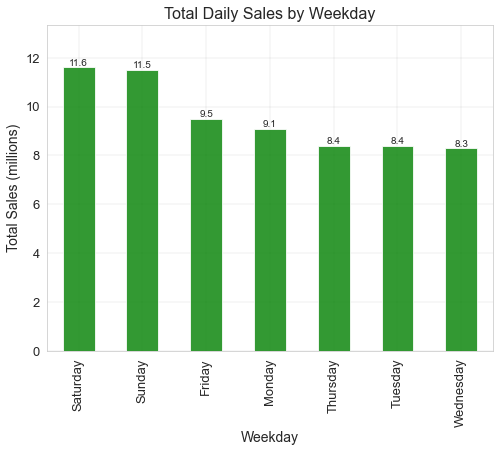

In [61]:
# Set seaborn as the style for the plot
sns.set_style("whitegrid")

# data
d = pd.DataFrame({'Total_daily_sales':no_filter().values, 'weekday':calendar['weekday'][0:-28].values})

weekday_sales = np.round(d.groupby('weekday')['Total_daily_sales'].sum()/1000000, 1).sort_values(ascending=False)

# plot the bar chart
ax = weekday_sales.plot(kind='bar', figsize=(8, 6), color="green", fontsize=13, alpha=0.8)

# Set the bar labels
for i in ax.containers:
    ax.bar_label(i, label_type='edge')

# Add chart title, x/y axis labels
ax.set_title('Total Daily Sales by Weekday', size=16)
ax.set_xlabel('Weekday', size=14)
ax.set_ylabel('Total Sales (millions)', size=14)

# Set the bar height for labels
ax.margins(y=0.15)

# Add gridlines
ax.grid(color='gray', linestyle='-', linewidth=0.25, alpha=0.5)

# save figure
plt.savefig("C:/Users/Igor/Desktop/PIBIC/PIBIC_2021-2022/images/barr_weekday.png", dpi=300, bbox_inches='tight')

# show image
plt.show()

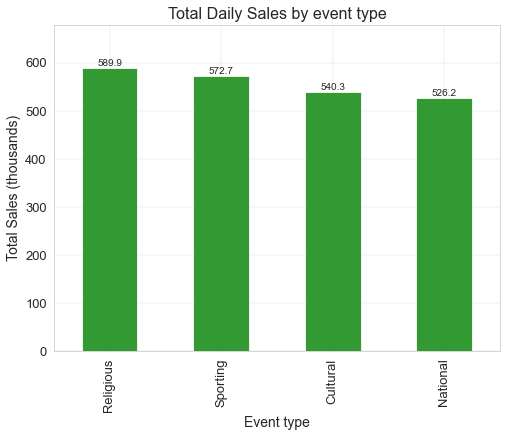

In [62]:
# Set seaborn as the style for the plot
sns.set_style("whitegrid")

# data
random.seed(22)

c = calendar.copy()
c = pd.Series(c['event_type_1'].values)
c.fillna('No_event', inplace =True)

d = pd.DataFrame({'Total_daily_sales':no_filter().values, 'Event_type':c[0:-28]})
random.seed(12)
releg = d[d['Event_type'] == 'Religious']['Total_daily_sales'].values
national = d[d['Event_type'] == 'National']['Total_daily_sales'].values
cult = d[d['Event_type'] == 'Cultural']['Total_daily_sales'].values
sport = d[d['Event_type'] == 'Sporting']['Total_daily_sales'].values
no = d[d['Event_type'] == 'No_event']['Total_daily_sales'].values

releg = random.sample(list(releg), 16)
national = random.sample(list(national), 16)
cult = random.sample(list(cult), 16)
no = random.sample(list(no), 16)

d = pd.DataFrame({'Religious':releg, 'National':national, 'Cultural':cult, 'Sporting':sport, 'No Event':no})

special_date_sales = np.round(d.sum().sort_values(ascending=False)[[0,1,2,4]]/1000, 1)

# plot the bar chart
ax = special_date_sales.plot(kind='bar', figsize=(8, 6), color="green", fontsize=13, alpha=0.8)

# Set the bar labels
for i in ax.containers:
    ax.bar_label(i, label_type='edge')

# Add chart title, x/y axis labels
ax.set_title('Total Daily Sales by event type', size=16)
ax.set_xlabel('Event type', size=14)
ax.set_ylabel('Total Sales (thousands)', size=14)

# Set the bar height for labels
ax.margins(y=0.15)

# Add gridlines
ax.grid(color='gray', linestyle='-', linewidth=0.25, alpha=0.5)

# save figure
plt.savefig("C:/Users/Igor/Desktop/PIBIC/PIBIC_2021-2022/images/barr_event.png", dpi=300, bbox_inches='tight')

# show image
plt.show()

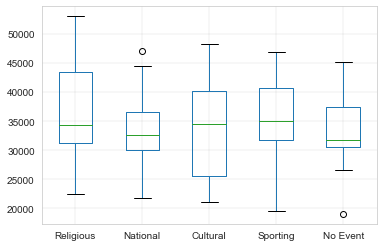

In [63]:
d.boxplot().grid(color='gray', linestyle='-', linewidth=0.25, alpha=0.5)

# save figure
plt.savefig("C:/Users/Igor/Desktop/PIBIC/PIBIC_2021-2022/images/box_plot_event.png", dpi=300, bbox_inches='tight')

# show image
plt.show()